## Car Lane Finding Project

First Import some packages. (Had some initial trouble with cv2, needed to activate Anaconda env restart Kernel) 

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio
import os
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
imageio.plugins.ffmpeg.download()
%matplotlib inline

Read in an test image, print out some statistics

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


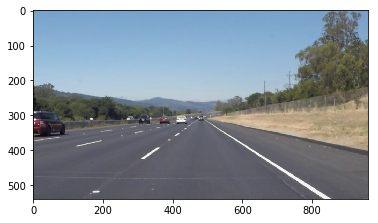

In [11]:

image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image,cmap='gray')  
# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

Helper Functions (Canny, HoughLine Detector, ROI Filter, Average Line Finder)

These get called for all calls to process all single images and video

In [53]:
import math

def threshold(rgb_threshold, image):
    """Applies a RGB array threshold to an image """ 
    # Note: always make a copy rather than simply using "="
    color_select = np.copy(image)
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    return color_select

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#  Add constant to numberator/denominator to avoid divide by zero
const_delta = .00001 
def average_lines(lines):
    """Averages HoughLines to get filter down to one positive and negative slope
    sums up all positive and negative slopes
    tries to avoid getting numerical errors with small delta on slope calc 
    """
    xp1=xp2=yp1=yp2=xn1=xn2=yn1=yn2=cn=cp=(0+const_delta)
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1+const_delta)/(x2-x1+const_delta)
            if m > 0:
                xp1+=x1
                xp2+=x2
                yp1+=y1
                yp2+=y2
                cp+=1
            else:
                xn1+=x1
                xn2+=x2
                yn1+=y1
                yn2+=y2
                cn+=1
    xp1=int(xp1/cp)
    xp2=int(xp2/cp)
    yp1=int(yp1/cp)
    yp2=int(yp2/cp)
    xn1 = int(xn1/cn)
    xn2 = int(xn2/cn)
    yn1=  int(yn1/cn)
    yn2=  int(yn2/cn)
    # Return averaged pos_line, neg_line       
    return [xp1,yp1],[xp2,yp2],[xn1,yn1],[xn2,yn2]


   
def calc_xtarget(x1,y1,x2,y2,ytarget):
    """ Simple Function to calculate extending line with slope equation mx+b 
        solve for y
    """
    m = (y2-y1+const_delta)/(x2-x1+const_delta)
    b = y1-m*x1
    return int((ytarget-b)/m)  #  Return int since we're talking pixels

def calc_ytarget(x1,y1,x2,y2,xtarget):
    """ Simple Function to calculate extending line with slope equation mx+b 
        solve for x
    """
    m = (y2-y1+const_delta)/(x2-x1+const_delta)
    b = y1-m*x1
    return int(m*xtarget+b)  #  Return int since we're talking pixels



def draw_lines(img, lines, color=[255, 0, 0], thickness=2,extend=False,averaged=False):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        if (averaged == True):
            [xp1,yp1],[xp2,yp2],[xn1,yn1],[xn2,yn2]=average_lines(lines)
            if extend == True:
                #calculate positive slope line and extend
                ybottom = image.shape[0] #  Lowest possible value in y  don't hard-code
                ytop =int(image.shape[0]*.593)
                xbottom = calc_xtarget(xp1,yp1,xp2,yp2,ybottom)
                xtop = calc_xtarget(xp1,yp1,xp2,yp2,ytop)
                cv2.line(img, (xbottom, ybottom), (xtop, ytop), color, thickness)
                #  Calculate negative slope line and extend 
                ynbottom = image.shape[0] #  Lowest possible value in y  don't hard-code
                yntop = int(image.shape[0]*.593)
                xnbottom = calc_xtarget(xn1,yn1,xn2,yn2,ynbottom)
                xntop = calc_xtarget(xn1,yn1,xn2,yn2,yntop)
                cv2.line(img, (xnbottom, ynbottom), (xntop,yntop), color, thickness)
             
            #  Else Don't do averaged method
        else:    
            for x1,y1,x2,y2 in line:
                # Extend Line
                if extend == True:
                    ytarget = 540 #  Lowest possible value in y  don't hard-code
                    xtarget = calc_xtarget(x1,y1,x2,y2,ytarget)
                    if (y2 < y1):
                        cv2.line(img, (xtarget, ytarget), (x2, y2), color, thickness)
                    else:
                        cv2.line(img, (x1, y1), (xtarget, ytarget), color, thickness)
                else:
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,[255,0,0],thickness=3,extend=True,averaged=True)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

Try on some test images - build a basic pipeline

solidWhiteCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


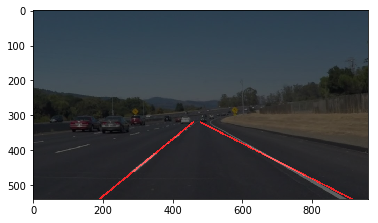

solidWhiteRight.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


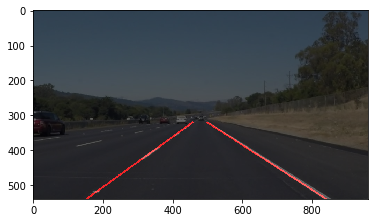

solidYellowCurve.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


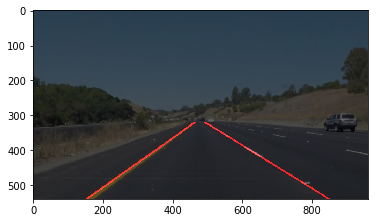

solidYellowCurve2.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


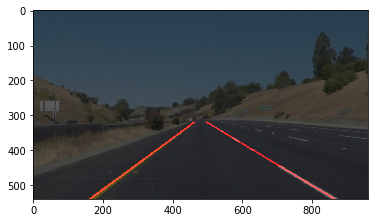

solidYellowLeft.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


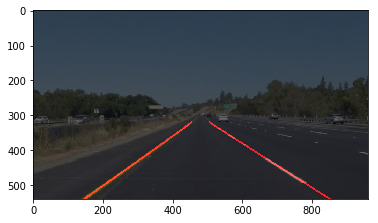

whiteCarLaneSwitch.jpg
This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


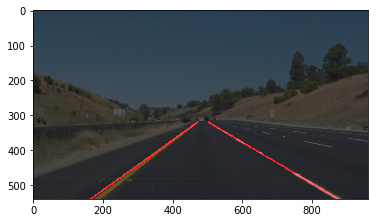

In [73]:
# **** Basic Pipeline  ****
# 1. Work on a copy
# 2. Threshold - Apply Gaussian (Blur) Filter, Canny Filter to find edges
# 3. Apply Region of Interest to Lanes
# 4. Find all clear lines of lane
# 5. Average all lines to 2 - positive and negative slope of left and right lane
# 6. Combine source and processed image, output files

        
def process_image(image):        
     # 1.Convert to Greyscale
    img_proc = np.copy(image)
    # Threshold
    rgb_threshold = [30, 30, 30]
    img_proc2 = threshold(rgb_threshold, img_proc)
    img_proc2 = gaussian_blur(img_proc2,5)
    # Canny Edge Detector  - img, low threshold, high threshold
    # reject pixels below low threshold, set edge at high treshold
    #  Reccomend a low to high ratio of 2 to 3 to find good edges
    img_proc2 = canny(img_proc2,75,150)
    #  Limit region of interest to lower center triangle
    xedge1 = int(xsize/16)
    xedge2 = int(xsize/16)
    yedge = int(ysize/18)
    quad_roc = np.array([[xedge1,ysize-yedge],[xsize-xedge1,ysize-yedge],\
                         [midpoint+xedge2,horiz],[midpoint-xedge2,horiz]],np.int32)
    img_proc2 = region_of_interest(img_proc2,[quad_roc])
    # Smooth and find Edges
    #  Scale to image shape using ysize, xsize, midpoint, and horiz   # Hough Lines  imag, rho, tehta, threshold, min_line_length, max_line_gap
    # rho, theta - angular resolution of grid in search space
    # threshold - minimum number of votes a candidate needs to have
    # min_line_length- minimum length of line it accepts in output
    # max_line_gap - maximum distance between segments  
    img_proc2=hough_lines(img_proc2, 1, 1*np.pi/180, 25, 60, 120)
    img_proc_final=weighted_img(img_proc2,img_proc,.4,.8,0)
    return img_proc_final
    
indir = "test_images"
os.listdir(indir)
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        print(f)
        fullpath = os.path.join(indir, f)
        image = mpimg.imread(fullpath)
        # Grab the x and y size and make a copy of the image
        ysize = image.shape[0]
        xsize = image.shape[1]
        #ysize,xsize,ncols = image.shape
        midpoint = int(xsize/2)
        horiz = int(ysize*.593)
        print('This image is: ',type(image), 
             'with dimensions:', image.shape)        
        processedimg = process_image(image)
        plt.imshow(processedimg)
        #plt.imshow(processedimg,cmap='Greys_r')
        plt.show()


In [58]:
white_output = 'test_videos_output/solidWhiteRight_output.mp4'
yellow_output = 'test_videos_output/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
#  Do Clip2  Yellow Output
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_output.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_output.mp4


100%|█████████▉| 250/251 [00:05<00:00, 46.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_output.mp4 

CPU times: user 6.47 s, sys: 1.06 s, total: 7.52 s
Wall time: 5.64 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_output.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_output.mp4


100%|█████████▉| 250/251 [00:05<00:00, 47.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_output.mp4 

CPU times: user 6.42 s, sys: 1.07 s, total: 7.49 s
Wall time: 5.62 s


In [59]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [61]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [75]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,10)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████▉| 250/251 [00:28<00:00,  8.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 31.4 s, sys: 2.27 s, total: 33.7 s
Wall time: 29.1 s


In [76]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(challenge_output))